# Variational quantum autoencoder

Circuit ansatz from: https://arxiv.org/pdf/2010.06599.pdf

In [1]:
import time
import numpy as np
from scipy.optimize import minimize, basinhopping
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
import matplotlib.pyplot as plt
%matplotlib inline

### Exact diagonalization 
In order to get ground state for input into quantum circuit

In [2]:
# from: https://tenpy.readthedocs.io/en/latest/toycodes/tfi_exact.html
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg.eigen.arpack as arp
import warnings
import scipy.integrate


def ising_groundstate(L, J, g):
    """For comparison: obtain ground state energy from exact diagonalization.

    Exponentially expensive in L, only works for small enough `L` <~ 20.
    """
    if L >= 20:
        warnings.warn("Large L: Exact diagonalization might take a long time!")
    # get single site operaors
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    sz_list = []
    for i_site in range(L):
        x_ops = [id] * L
        z_ops = [id] * L
        x_ops[i_site] = sx
        z_ops[i_site] = sz
        X = x_ops[0]
        Z = z_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sx_list.append(X)
        sz_list.append(Z)
    H_xx = sparse.csr_matrix((2**L, 2**L))
    H_z = sparse.csr_matrix((2**L, 2**L))
    for i in range(L - 1):
        H_xx = H_xx + sx_list[i] * sx_list[(i + 1) % L]
    for i in range(L):
        H_z = H_z + sz_list[i]
    H = -J * H_xx - g * H_z
    E, V = arp.eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
    return V[:,0], E[0]
init_state, E = ising_groundstate(6, 1., 1.)

### Define variational quantum circuit
At the moment only works for 6 quibts (two of them are trash qubits).

Other ansatze that might be worth trying: PauliTwoDesign, RealAmplitudes, EfficientSU2

In [3]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

L = 6 # system size
thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, (2*L+2, 2)) # initial parameters with feature encoding

In [4]:
def sort_vals(vals):
    """ vals is (unsorted) dictionary of parameters from VQE ansatz circuit, this returns sorted values as list """
    indices = np.array([_.index for _ in vals])           # unordered list of indices from the ParameterVectorElement(Theta(INDEX))
    vals_sorted = np.array([vals[_] for _ in vals])       # unordered list of values (but same ordering as indices)
    return vals_sorted[np.argsort(indices)]

def init_vqe(vals):
    return qiskit.circuit.library.EfficientSU2(L, reps=3).assign_parameters(sort_vals(vals))

In [9]:
L = 6
VQE_vals = np.load(f'params_VQE_ising_N{L}.npy', allow_pickle=True).item()

lambdas = np.array([_ for _ in VQE_vals]) # list of lambda values (the items in the dictionary)
# note that Rike calls them gs

In [10]:
lambdas

array(['0.01', '0.027825594022071243', '0.0774263682681127',
       '0.21544346900318834', '0.5994842503189409', '1.6681005372000592',
       '4.6415888336127775', '12.915496650148826', '35.93813663804626',
       '100.0'], dtype='<U20')

In [13]:
def prepare_circuit(init_state=None, measurement=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(2, 'c')
    circ = QuantumCircuit(qreg, creg)
    entangler_map1 = [(5, 4), (5, 3), (5, 1), (4, 2), (4, 0)]
    entangler_map2 = [(5, 4), (5, 2), (4, 3), (5, 0), (4, 1)]
    circ += circuit.library.TwoLocal(L, 'ry', 'cz', entanglement = [entangler_map1, entangler_map2], reps=2, insert_barriers=True, skip_final_rotation_layer=True)
    circ.ry(circuit.Parameter('θ1'), 4)
    circ.ry(circuit.Parameter('θ2'), 5)
    if measurement:
        circ.measure(qreg[4], creg[0])
        circ.measure(qreg[5], creg[1])
    if init_state is not None: 
        circ = init_vqe(init_state) + circ
    
    return circ

# same circuit as above (more explicit)
def prepare_circuit2(thetas, init_state=None, measurement=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(2, 'c')
    circ = QuantumCircuit(qreg, creg)
    #if init_state is not None: circ.initialize(init_state, qreg)
    for i,t in enumerate(thetas[:L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,3)
    circ.cz(5,1)
    circ.cz(4,2)
    circ.cz(4,0)
    for i,t in enumerate(thetas[L:2*L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,2)
    circ.cz(4,3)
    circ.cz(5,0)
    circ.cz(4,1)
    circ.ry(thetas[2*L], 4)
    circ.ry(thetas[2*L+1], 5)
    if measurement:
        circ.measure(qreg[4], creg[0])
        circ.measure(qreg[5], creg[1])
    if init_state is not None: 
        circ = init_vqe(init_state) + circ
    return circ

In [14]:
def feature_encoding(thetas, x):
    """ thetas: parameters to be optimized, x: Ising model parameter (eg. field) """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

<ipython-input-13-a912210952f8>:14: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = init_vqe(init_state) + circ
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


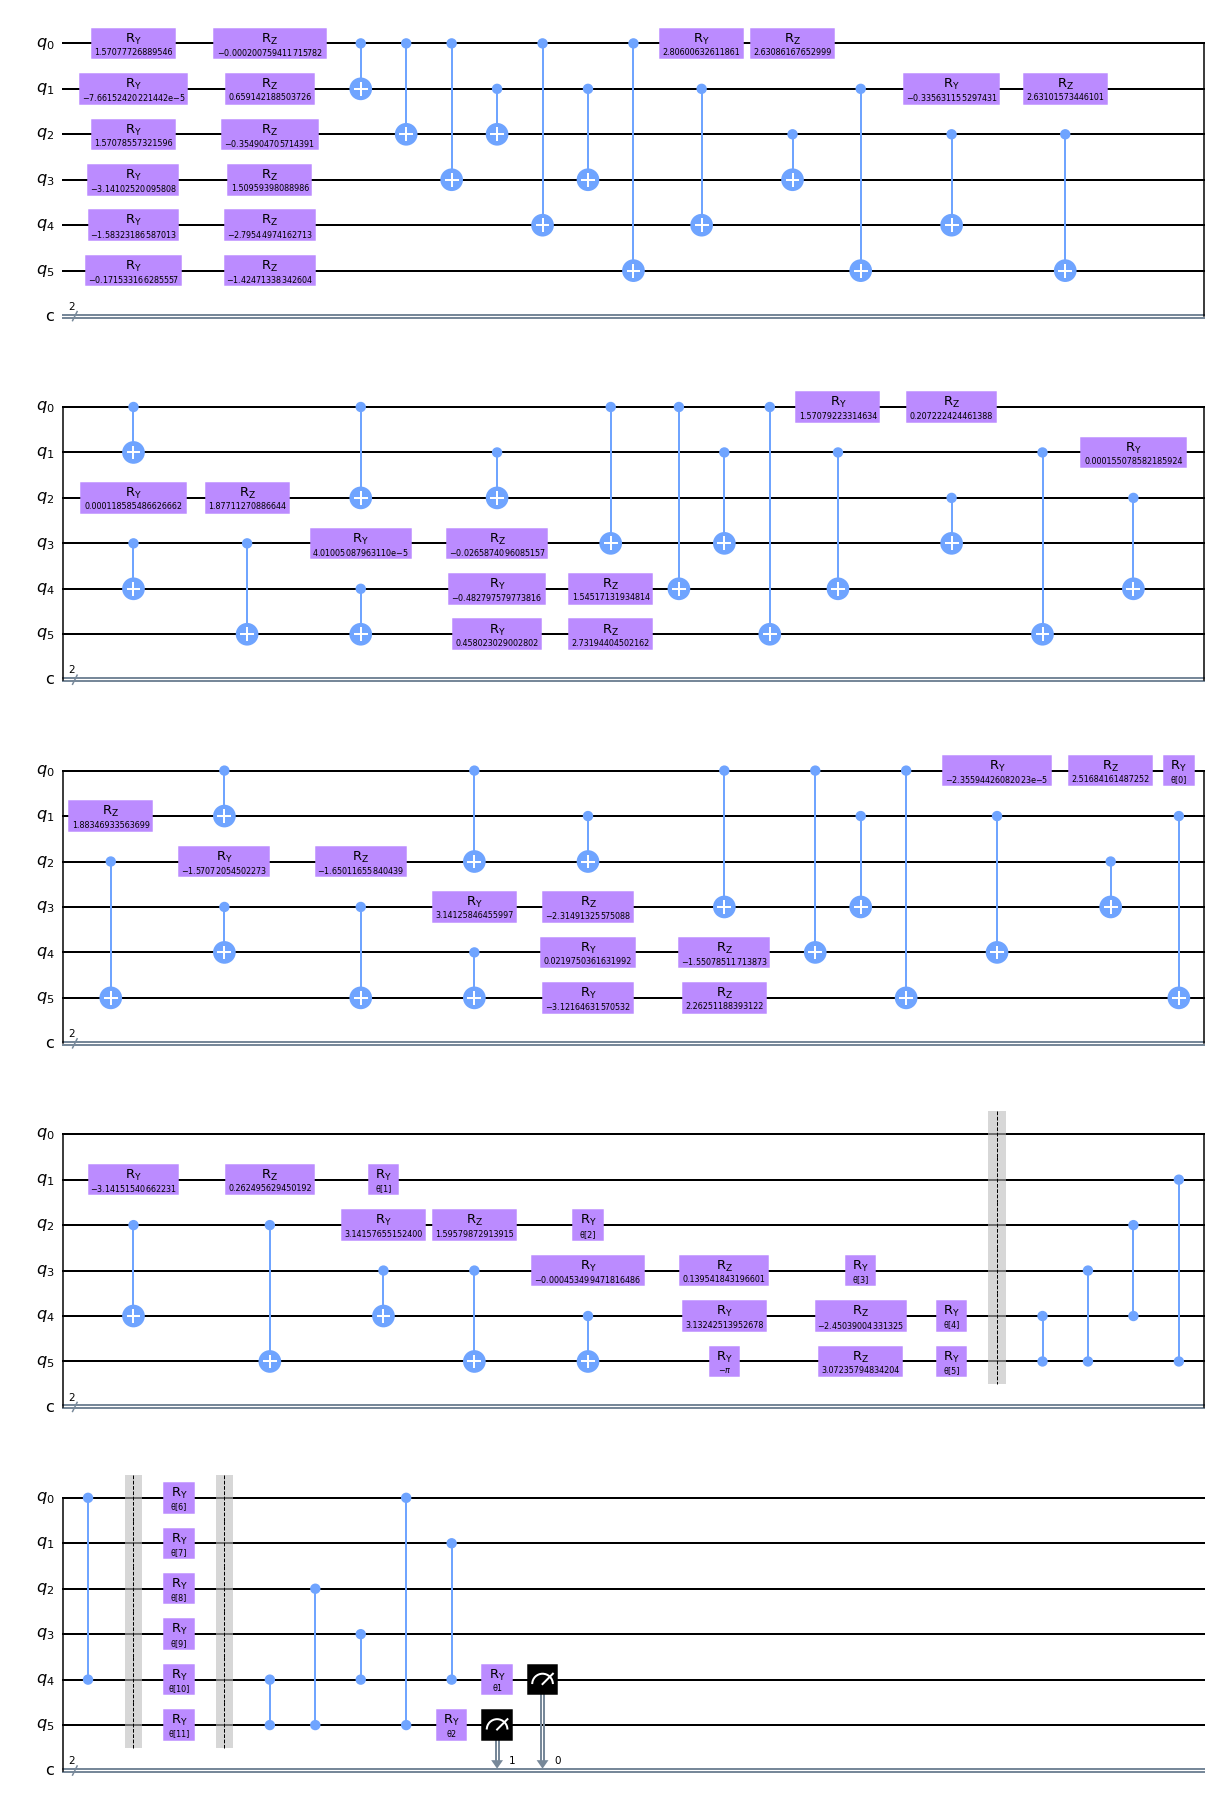

In [17]:
circ = prepare_circuit(init_state=VQE_vals[lambdas[0]])
t_qc = transpile(circ, backend=backend_sim)

circ.draw('mpl') # trash qubits are at the bottom

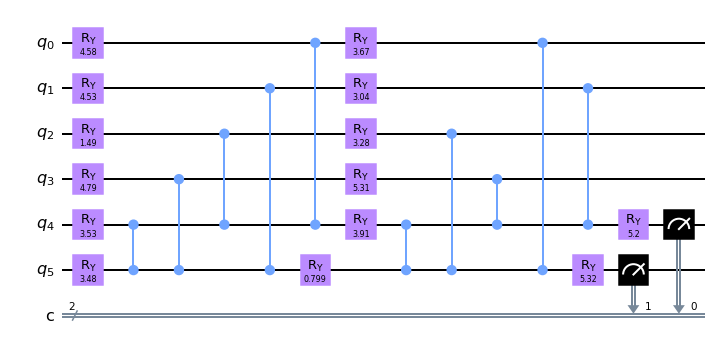

In [120]:
circ = prepare_circuit2(thetas)
# circ = prepare_circuit(feature_encoding(thetas, .6))
circ.draw('mpl') # identical to above

### Execute circuit
Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [15]:
def run_circuit(thetas, init_state, shots=100):
    circ = prepare_circuit2(thetas, init_state)

    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots)#, memory=True)

    # Grab the results from the job.
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circ)
#     print(counts)
    
#     mems = result_sim.get_memory(circ)
#     print(mems)
    return counts
run_circuit(thetas, init_state)['11']

26

### Optimize circuit
Define cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [130]:
J, g = 1., lambdas[0] # Ising parameters for which ground state should be compressed
init_state = VQE_vals[lambdas[0]] # train on smallest lambda ;; this may grammatically be confusing, init_state = dictionary with unsorted parameters
circ = prepare_circuit(init_state)
t_qc = transpile(circ, backend=backend_sim)

def cost_function_single(thetas, t_qc):
    """ Optimizes circuit for single input state """
    shots = 1000 # Number of measurements for single training example
    qobj = compiler.assemble(t_qc.bind_parameters(thetas), backend=backend_sim, shots=shots)
    result = backend_sim.run(qobj).result()
    out = result.get_counts()
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots
cost_function_single(thetas, t_qc)

0.577

In [131]:
thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, ((2*L+2)*2)) # initial parameters with feature encoding

# counts, values = [], []
# def store_intermediate_result(eval_count, parameters, mean, std):
#     counts.append(eval_count)
#     values.append(mean)

# Initialize optimizer
optimizer = COBYLA(maxiter=50, tol=0.0001)
# optimizer = L_BFGS_B(maxfun=300, maxiter=500)#, factr=10, iprint=- 1, epsilon=1e-08)
# optimizer = SPSA(maxiter=1)#, callback=store_intermediate_result) # recommended from qiskit but terribly slow

start_time = time.time()
ret = optimizer.optimize(num_vars=thetas.shape[0], objective_function=(lambda thetas: cost_function_single(thetas, t_qc)), initial_point=thetas)
print("Time: ", time.time()-start_time)
ret

Time:  0.6885499954223633


(array([ 0.60845968,  4.68432125,  6.73824597,  5.09380408,  0.11946011,
         1.67894324,  3.59105617,  1.87477794,  4.4136599 ,  5.03819992,
         2.01876115,  5.08789994,  3.20525082, -0.46532493]),
 0.479,
 50)

In [135]:
thetas = ret[0]

In [139]:
def run_circuit(thetas, init_state, shots=100):
    circ = prepare_circuit2(thetas, init_state)

    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots)#, memory=True)

    # Grab the results from the job.
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circ)
#     print(counts)
    
#     mems = result_sim.get_memory(circ)
#     print(mems)
    return counts
run_circuit(thetas, init_state)['11']

16

### Test circuit
Test optimized circuit on different Ising parameter values and (hopefully) observe phase transition

In [143]:
gs = np.linspace(0.01, 2.0, 50)
gs = [1.0, 1.5, 2.0]
cost = []
shots = 10000
for g in lambdas:
    new_thetas = thetas
    out = run_circuit(new_thetas, VQE_vals[g], shots=shots)
    cost.append((out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0))/shots)

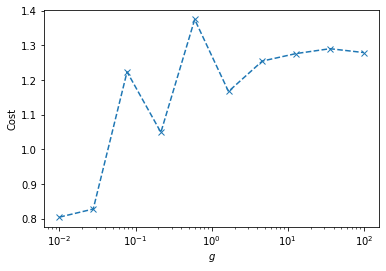

In [147]:
plt.plot(lambdas, cost,"x--")
plt.xlabel(r"$g$")
plt.ylabel("Cost")
plt.xscale("log")